Once deleted, variables cannot be recovered. Proceed (y/[n])? y


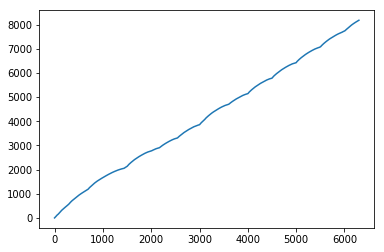

[]

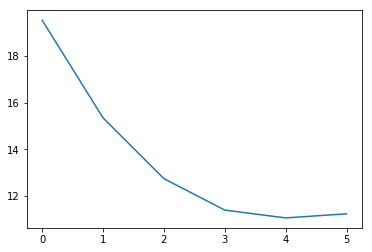

In [60]:
#Adaptive setting: Our epoch based algorithm
% reset
import numpy as np;
import numpy.random as ra;
import scipy.linalg as sla;
import numpy.linalg as la;
import pdb;
import scipy.io as sio
import matplotlib.pyplot as plt


yahoo_content = sio.loadmat('Yahoo')

my_context = yahoo_content['context_matrix']

my_reward1 = yahoo_content['expected_reward']

my_reward = np.transpose(my_reward1)

#parameters
epoch_num = 6
num_trials = 20
N_epoch = 100 # Length of the first epoch
N = N_epoch * ((2** epoch_num) - 1)  # Horizon/number of observations

trial_reg = np.zeros(N)
trial_estnorm = np.zeros(epoch_num)

for trial in range(num_trials):



    N_epoch = 100 # Length of the first epoch
    
    N = N_epoch * ((2** epoch_num) - 1)  # Horizon/number of observations
    d = 50   # number of covariates
    n_a = 500  # number of arms/actions
    #S = 5   # norm of theta_star, b in our algorithm
    R = 0.01;
    S_hat = 25 # initial norm estimate of theta_star

    ridge = 0.1;
    delta = 0.005;


    #- generate theta_star
    #v = ra.normal(0,1,d);
    #v /= la.norm(v)
    #theta_star = v * S;


    #norms = la.norm(X);
    #X /= norms.reshape(-1,1)
    #X = X;

    # Bias
    #bias = ra.uniform(-1,1,n_a);

    # Pure exploration
    X_p = my_context;
    reward_p = my_reward;
    times = np.ones(n_a);
    avg_reward = reward_p



    XTy = np.zeros(d)
    invVt = np.eye(d) / ridge
    #X_invVt_norm_sq = np.sum(X * X, axis=1) / ridge;
    logdetV = d * np.log(ridge);
    sqrt_beta =  R * np.sqrt( logdetV - d * np.log(ridge) + np.log(1/(delta**2)) ) + np.sqrt(ridge) * S_hat
    theta_hat = np.zeros(d);
    Vt = ridge * np.eye(d); 
    my_c = .1 # Agressiveness (inv)
    my_c1 = 2

    sum_val = 0

    def ofulplus(S_hat, N_epoch, delta, XTy, invVt, logdetV, sqrt_beta, theta_hat, Vt, sum_val):

        X = np.array([my_context, ]*N_epoch)
        # X = ra.normal(0,1,(N_epoch, n_a, d)) #- generate X
        # Regret
        cum_reg = np.zeros(N_epoch)
        #- save expected rewards
        expt_reward = np.array([my_reward, ]*N_epoch);
        best_arm_vec = np.argmax(expt_reward, axis = 1);

        tilde_mu = avg_reward[0] + (R * 2 * np.sqrt(np.log(n_a/delta)) + S_hat * np.sqrt(2*d * np.sqrt(np.log(1/delta))))



        for t in range(N_epoch):

        #For t = 0 choose randomly

            x = X[t]
            best_arm = best_arm_vec[t]
            X_invVt_norm_sq = np.sum(np.dot(x, invVt) * x, 1)
            obj_func = tilde_mu + np.dot(x, theta_hat)  + my_c * sqrt_beta * np.sqrt(X_invVt_norm_sq) 
            pulled_idx = np.argmax(obj_func);  # Pull the arm with the highest estimated value
            #pulled_idx = np.random.randint(0, n_a)  # Pull a random arm

            xt = x[pulled_idx, :]
            reward = my_reward[0][pulled_idx] 
            times[pulled_idx] += 1
            term1 = ((1+times[pulled_idx])/(times[pulled_idx]**2))
            term2 = np.log((n_a * np.sqrt(1+times[pulled_idx]))/delta)
            term3 = R * np.sqrt(term1 *(1+2 * term2))
            term4 = S_hat * np.sqrt((2*d/times[pulled_idx]) * np.log(1/delta))
            tilde_mu[pulled_idx] = (((times[pulled_idx] - 1)*avg_reward[0][pulled_idx]) + reward)/times[pulled_idx] + term3 + term4

            #reg = bias[best_arm] + np.dot(x[best_arm,:],theta_star) - bias[pulled_idx] - np.dot(xt, theta_star)
            reg = reward
            sum_val = sum_val + reg

            cum_reg[t] = sum_val

            XTy += reward * xt
            Vt += np.outer(xt, xt);

            tempval1 = np.dot(invVt, xt)    # d by 1, O(d^2)
            tempval2 = np.dot(tempval1, xt)      # scalar, O(d)
            logdetV += np.log(1 + tempval2);

            if (t % 200 == 0):
                invVt = la.inv(Vt);
        #		X_invVt_norm_sq -= (np.dot(x, tempval1) ** 2) / (1 + tempval2) # efficient update, O(Nd)
            else:
                invVt -= np.outer(tempval1, tempval1) / (1 + tempval2) 
        #       X_invVt_norm_sq -= (np.dot(x, tempval1) ** 2) / (1 + tempval2) # efficient update, O(Nd)

            theta_hat = np.dot(invVt, XTy)
            #print(theta_hat)

            sqrt_beta = R * np.sqrt( logdetV - d * np.log(ridge) + np.log(1/(delta**2)) ) + np.sqrt(ridge) * S_hat

        S_hat = la.norm(theta_hat) + my_c1 * sqrt_beta

        return theta_hat, S_hat, cum_reg, XTy, invVt, logdetV, sqrt_beta, Vt, sum_val






    tot_reg = []
    est_norm = []

    for i in range(epoch_num):
        theta_hat, S_hat, cum_reg, XTy, invVt, logdetV, sqrt_beta, Vt, sum_val = ofulplus(S_hat, N_epoch, delta, XTy, invVt, logdetV, sqrt_beta, theta_hat, Vt, sum_val)

        N_epoch = 2*N_epoch
        delta = delta/2
        est_norm.append(S_hat)
        tot_reg = np.concatenate((tot_reg,cum_reg), axis=None)

    trial_reg = trial_reg + tot_reg 
    trial_estnorm = trial_estnorm + est_norm


avg_trial_reg = trial_reg/num_trials
avg_estnorm = trial_estnorm/num_trials

plt.plot(avg_trial_reg)
plt.show()

plt.plot(avg_estnorm)
plt.plot()

2.4545454545454546

In [61]:
import scipy.io as sio
import numpy as np

fname1='yahoo_reg_25'

my_a={}
my_a['reg']=np.array(avg_trial_reg)
sio.savemat(fname1,my_a)

fname2 = 'yahoo_theta_25'
my_b={}
my_b['reg']=np.array(avg_estnorm)
sio.savemat(fname2,my_b)